In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Objective

This project focuses on forecasting enterprise license usage for a specific license subscription trend by analyzing historical monthly data of Microsoft 365 Enterprise License activations. The goal is to help the IT procurement team better plan and allocate resources, such as license allocations and IT resources, during peak periods. Various time series analysis techniques have been applied, and different models have been fitted to generate accurate forecasts.

# Data Loading

In [2]:
data = pd.read_csv('license-usage-trends.csv', header = None)
data.columns = ['Month','ActiveLicenses']
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data = data.set_index('Month')
data.head(12)

,ActiveLicenses
Month,
2013-02-01,118.0
2013-03-01,132.0
2013-04-01,129.0
2013-05-01,121.0
2013-06-01,135.0
2013-07-01,148.0
2013-08-01,148.0
2013-09-01,136.0
2013-10-01,119.0


In [3]:
data.shape

(143, 1)

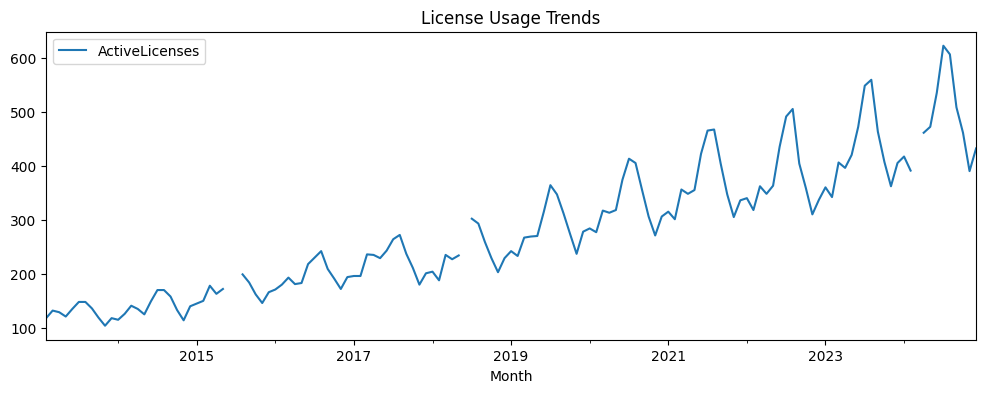

In [4]:
data.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('License Usage Trends')
plt.show(block=False)

The data is monthly data with increasing trend over the years.

# Handling Missing Values

Linear Interpolation for Missing Value Imputation

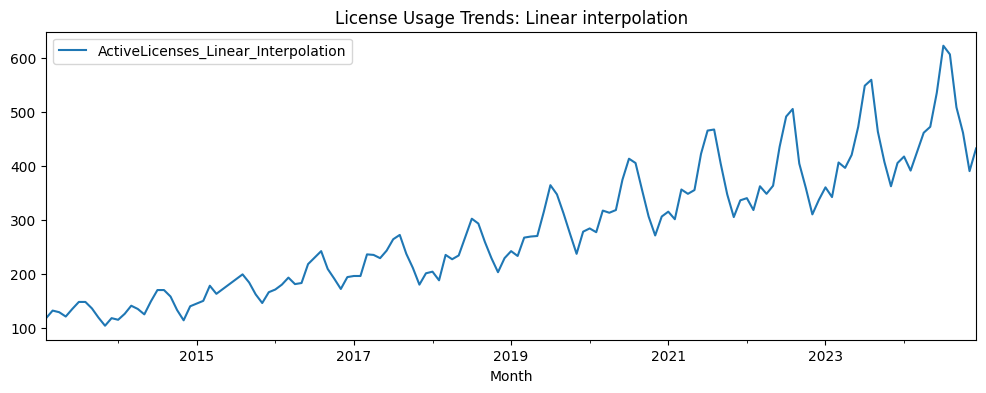

In [5]:
data = data.assign(ActiveLicenses_Linear_Interpolation=data.ActiveLicenses.interpolate(method='linear'))
data[['ActiveLicenses_Linear_Interpolation']].plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title('License Usage Trends: Linear interpolation')
plt.show(block=False)

In [6]:
data['ActiveLicenses'] = data['ActiveLicenses_Linear_Interpolation']
data.drop(columns=['ActiveLicenses_Linear_Interpolation'],inplace=True)

# Time Series Decomposition

Additive Seasonal Decomposition

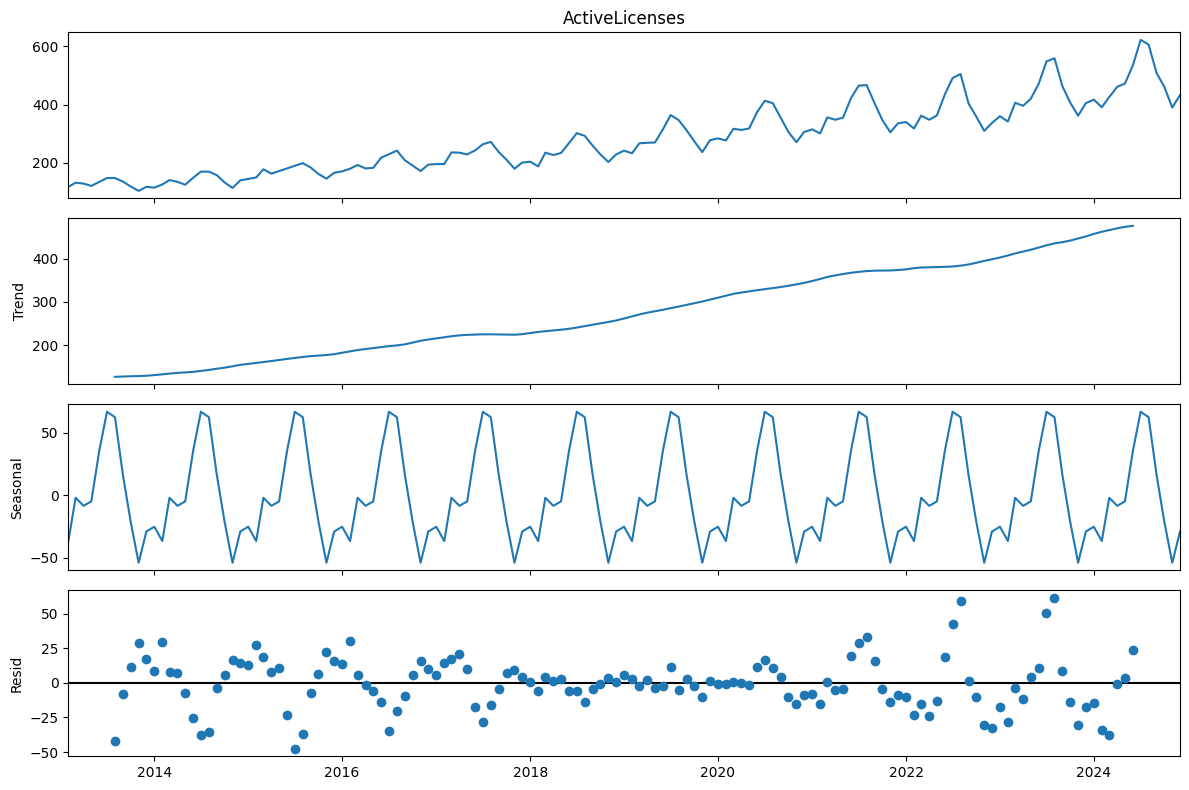

In [7]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(data.ActiveLicenses, model='additive') # additive seasonal index
fig = decomposition.plot()
plt.show()

The data is monthly data with increasing trend over the years.
There is a rising trend. There is also seasonality in data, which repeats over the year. Even after capturing seasonality, the residuals still show some amount of seasonality which cannot be explained. Let us check the multiplicative seasonality.

Multiplicative Seasonal Decomposition

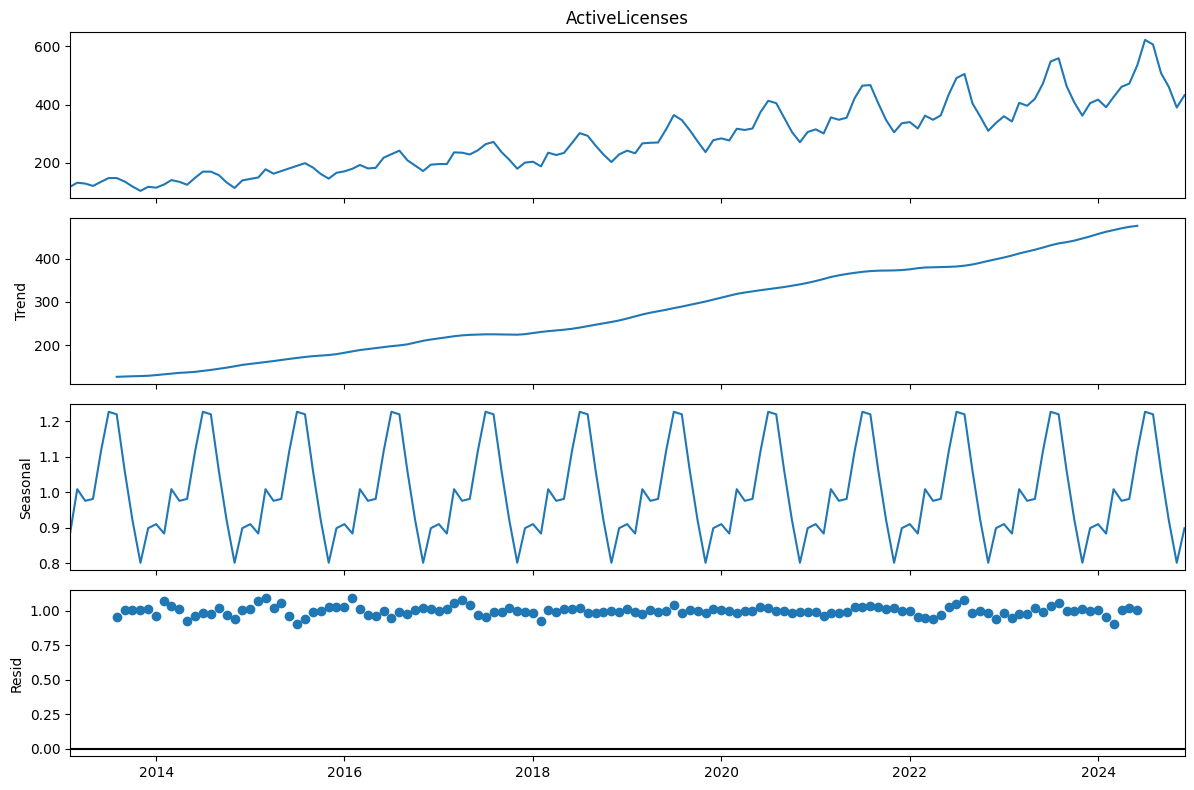

In [8]:
decomposition = sm.tsa.seasonal_decompose(data.ActiveLicenses, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

Here also rising trend and seasonality shown. But here the residuals look random and dont follow any particular pattern.

# Splitting Time Series Data in Train and Test Sets

In [9]:
train_len = 120
train = data[0:train_len]
test = data[train_len:]

# Stationarity Tests

Augmented Dickey-Fuller Test

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train['ActiveLicenses'])

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -0.469122
Critical Values @ 0.05: -2.89
p-value: 0.897903


p value greater than 0.05.

Kwiatkowski-Phillips-Schmidt-Shin Test

In [11]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train['ActiveLicenses'])

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 1.704234
Critical Values @ 0.05: 0.46
p-value: 0.010000


p value less than 0.05.

Inference: Both the tests indicate that the series is non stationary. Transformations need to be done to make the non stationary series stationary.

Boxcox transformation to make variance constant. Setting lambda as 0 indicating a simple log transformation.

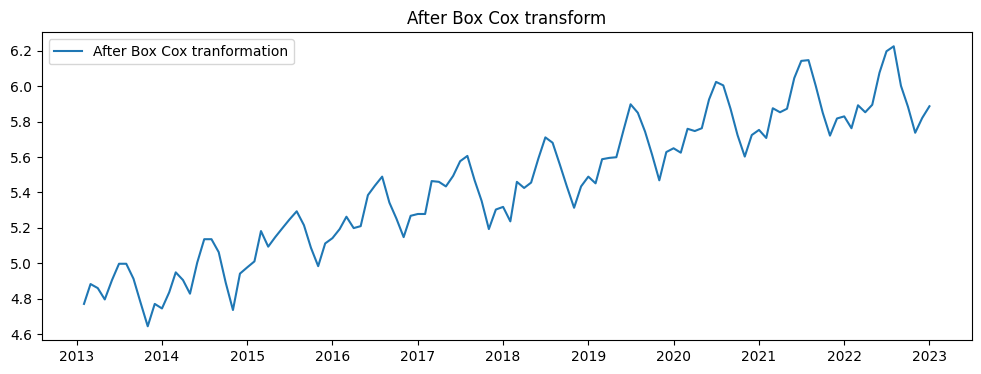

In [12]:
from scipy.stats import boxcox

lmbda=0

train_boxcox = pd.Series(boxcox(train['ActiveLicenses'], lmbda=lmbda), index = train.index)

plt.figure(figsize=(12,4))
plt.plot(train_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

Now we notice that the fluctuations have become somewhat uniform. But the rising trend still exists.

First Order Differencing

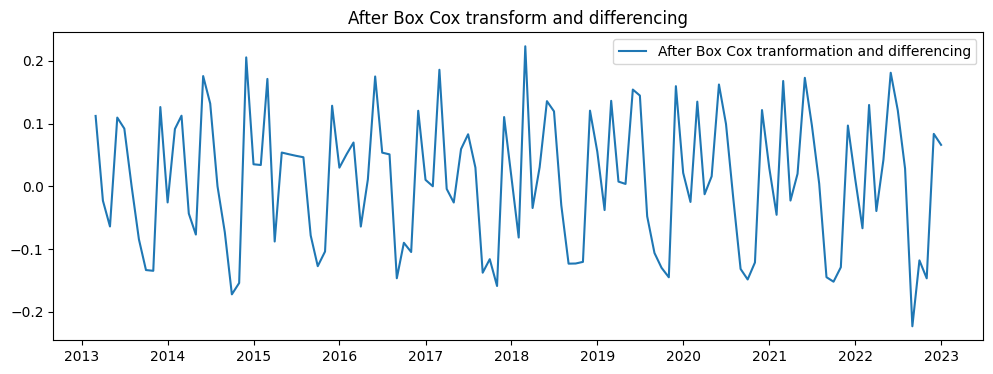

In [13]:
train_boxcox_diff = pd.Series(train_boxcox - train_boxcox.shift(), train.index)
plt.figure(figsize=(12,4))
plt.plot(train_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [14]:
train_boxcox_diff=train_boxcox_diff.dropna()

Again stationarity test

In [15]:
adf_test = adfuller(train_boxcox_diff)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %f' % adf_test[1])

ADF Statistic: -2.718109
Critical Values @ 0.05: -2.89
p-value: 0.070957


In [16]:
from statsmodels.tsa.stattools import kpss
kpss_test = kpss(train_boxcox_diff)

print('KPSS Statistic: %f' % kpss_test[0])
print('Critical Values @ 0.05: %.2f' % kpss_test[3]['5%'])
print('p-value: %f' % kpss_test[1])

KPSS Statistic: 0.020630
Critical Values @ 0.05: 0.46
p-value: 0.100000


Inference - For adfuller test, p value has decreased drastically from 0.8 to 0.08. It is not below 0.05 but still closer. For KPSS test, p value has increased to 0.1 from 0.01 and it is well above 0.05. So we can consider this stationary.

# ACF and PCF

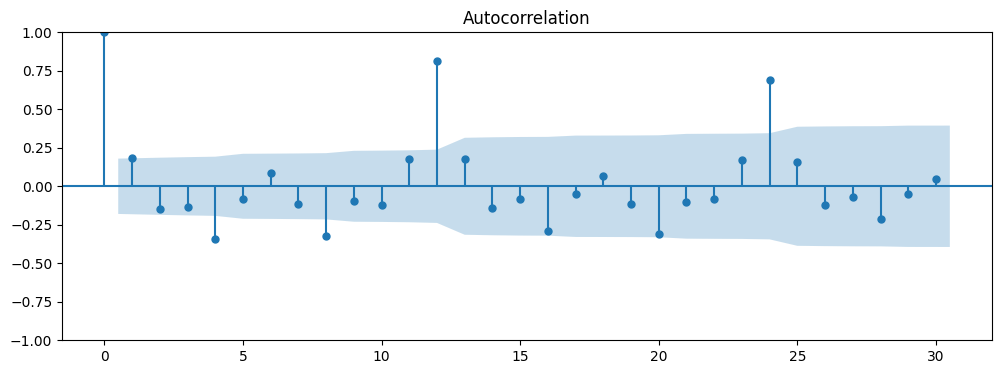

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

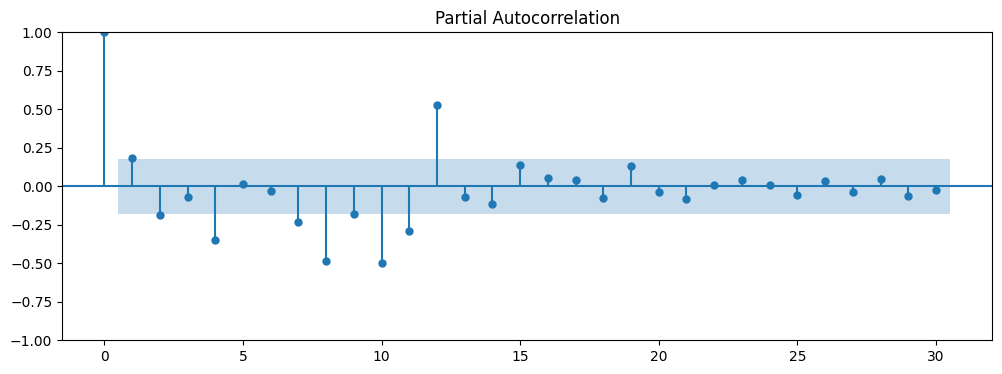

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(train_boxcox_diff, ax=plt.gca(), lags = 30)
plt.show()

The ACF and PACF shows high correlation at specific points. So there is seasonality in the data. Let us try to fit SARIMA (Seasonal Autoregressive Integrated Moving Average) model.

# SARIMA Model

In [19]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00


In [20]:
from pmdarima import auto_arima

The data is monthly data with seasonality repeating yearly. So seasonal period m is 12.Since after first order differencing , data became stationary, we select d=1.

In [21]:
stepwise_fit = auto_arima(train_boxcox, start_p = 0, start_q = 0,
                          max_p=1, max_q=1,
                          m = 12,
                          seasonal = True,
                          d = 1, D = 1, start_P=0, start_Q=0,
                          max_P=3, max_Q=3,
                          trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)


stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-355.418, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-379.906, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-385.862, Time=0.93 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-361.435, Time=0.14 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-384.147, Time=3.00 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-384.153, Time=5.00 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-382.297, Time=3.79 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=13.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.370, Time=1.30 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-385.803, Time=6.44 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-384.329, Time=0.68 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-383.976, Time=1.30 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total fit time: 36.698 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 195.931
Date:                            Tue, 11 Mar 2025   AIC                           -385.862
Time:                                    17:48:48   BIC                           -377.843
Sample:                                02-01-2013   HQIC                          -382.611
                                     - 01-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3219      0.089     -3.624      0.000      -0.496      -0.148
ma.S.L12      -0.5384      0.107     -5.027      0.000      -0.748      -0.328
sigma2         0.0014      0.000      7.756      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.78   Prob(JB):                         0.76
Heteroskedasticity (H):               0.35   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
model = SARIMAX(train_boxcox, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit()
print(model_fit.params)

ma.L1      -0.321916
ma.S.L12   -0.538361
sigma2      0.001445
dtype: float64


# Forecasting On SARIMA

Applying BoxCox with lambda=0 on test data

In [23]:
test_boxcox = pd.Series(boxcox(test['ActiveLicenses'], lmbda=lmbda), index = test.index)
test_boxcox_diff = pd.Series(test_boxcox - test_boxcox.shift(), test.index)
test_boxcox_diff=test_boxcox_diff.dropna()

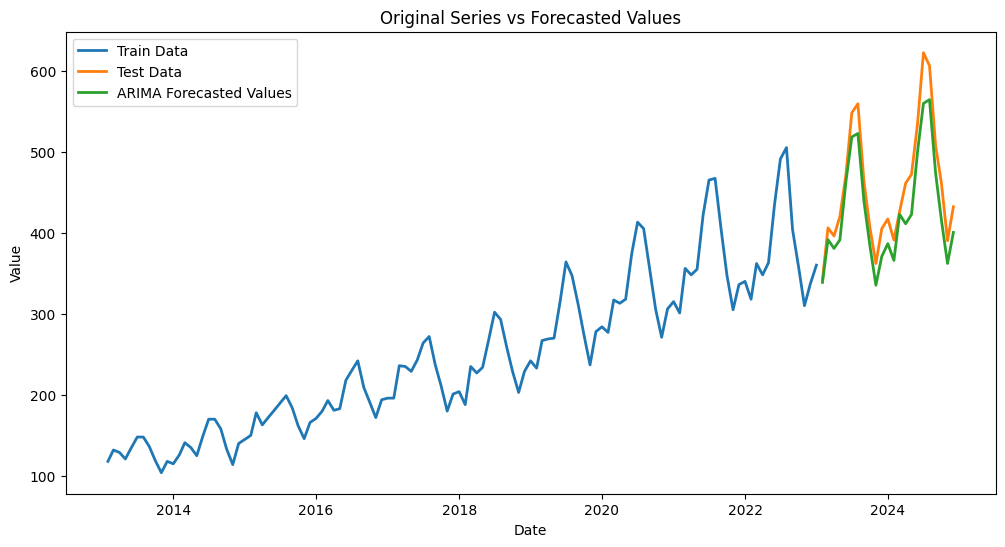

In [24]:
forecast_diff1 = model_fit.predict(start=test_boxcox.index[0], end=test_boxcox.index[-1])
forecast_original = np.exp(forecast_diff1)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
#plt.plot(forecast_original[len(train):], label='ARIMA Forecasted Values', linewidth=2)
plt.plot(forecast_original.index,forecast_original, label='ARIMA Forecasted Values', linewidth=2)



plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()


plt.show()


In [25]:
assert len(forecast_original) == len(test)
assert all(forecast_original.index == test.index)

rmse = np.sqrt(mean_squared_error(test['ActiveLicenses'], forecast_original)).round(2)
mape = np.round(np.mean(np.abs((test['ActiveLicenses'] - forecast_original) / test['ActiveLicenses'])) * 100, 2)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

RMSE: 32.96
MAPE: 6.35%


# SARIMAX Model

The data below represents seasonal license renewal cycles or promotional discounts organized by the vendors at various times throughout the year. These seasonal license renewal cycles or promotional discounts serve as exogenous variables that impact the usage during specific periods. To analyze this relationship, SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) is utilized.

In [26]:
promo = pd.read_csv('license-renewal-campaigns-and-promotions.csv', header = None)
promo.columns = ['Month','Event']
promo['Month'] = pd.to_datetime(promo['Month'], format='%Y-%m')
promo = promo.set_index('Month')
promo

,Event
Month,
2013-02-01,0
2013-03-01,0
2013-04-01,0
2013-05-01,0
2013-06-01,0
...,...
2024-08-01,1
2024-09-01,1
2024-10-01,1


In [27]:
promo_train = promo[:train_len]
promo_test = promo[train_len:]

In [28]:
model = SARIMAX(train_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=promo_train)
model_fit = model.fit()
print(model_fit.params)

Event       0.034343
ar.L1       0.472201
ma.L1      -0.744728
ar.S.L12   -0.072158
ma.S.L12   -0.553020
sigma2      0.001341
dtype: float64


# Forecasting on SARIMAX

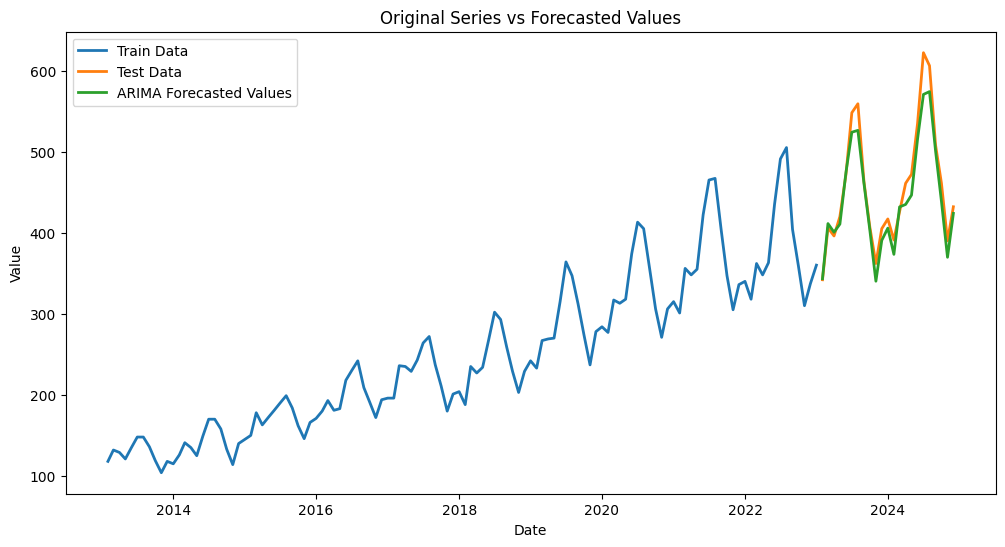

In [29]:
forecast_diff = model_fit.predict(start=test_boxcox.index[0], end=test_boxcox.index[-1], exog=promo_test)
forecast_original = np.exp(forecast_diff)

plt.figure(figsize=(12, 6))

# Plot the original training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot the original test data
plt.plot(test.index, test, label='Test Data', linewidth=2)

# # Plot the forecasted values (forecast_original) on top of the original series
plt.plot(forecast_original.index,forecast_original, label='ARIMA Forecasted Values', linewidth=2)



plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Forecasted Values')
plt.legend()


plt.show()


In [30]:
assert len(forecast_original) == len(test)
assert all(forecast_original.index == test.index)

rmse = np.sqrt(mean_squared_error(test['ActiveLicenses'], forecast_original)).round(2)
mape = np.round(np.mean(np.abs((test['ActiveLicenses'] - forecast_original) / test['ActiveLicenses'])) * 100, 2)
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

RMSE: 20.19
MAPE: 3.34%


# Test

Rolling forecast

In [40]:
past_promo_exog = promo_test.copy()

In [31]:
promo_2025 = promo_test[-12:].reset_index(drop=True)  # assuming last year's promotion data patterns
promo_2025.index = pd.date_range(start="2025-01", periods=12, freq="M")

In [47]:
from scipy.special import inv_boxcox


rolling_forecast_2025 = []

# Start forecasting from January 2025
current_start = test.index[-1]


In [42]:
# Rolling forecast for 12 months
for i in range(12):
    # Define the next month's index
    next_month = current_start + pd.DateOffset(months=1)

    # Extract corresponding exogenous variable for that month (convert to 2D array)
    next_promo = pd.DataFrame([promo_2025.iloc[i]], index=[next_month])

    past_promo_exog = pd.concat([past_promo_exog, next_promo])

    # Generate one-step-ahead prediction
    next_forecast_diff = model_fit.predict(start=next_month, end=next_month, exog=past_promo_exog)

    # Convert back to original scale (since lambda=0, use np.exp)
    next_forecast_original = np.exp(next_forecast_diff.values[0])

    # Store result
    rolling_forecast_2025.append((next_month, next_forecast_original))

    # Update current_start for the next iteration
    current_start = next_month

In [43]:
# Convert rolling predictions to a DataFrame
rolling_forecast_2025_df = pd.DataFrame(rolling_forecast_2025, columns=["Month", "ActiveLicenses"]).set_index("Month")

# Append 2025 forecast to 2024 forecast
full_forecast_original = pd.concat([forecast_original, rolling_forecast_2025_df])

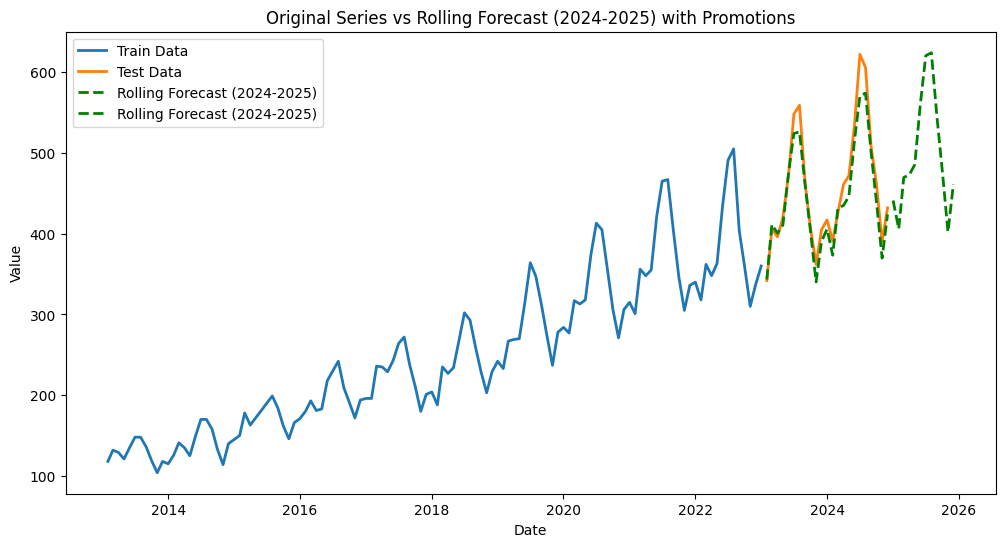

In [46]:
# Plot updated forecast including 2025
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train.index, train, label='Train Data', linewidth=2)

# Plot test data
plt.plot(test.index, test, label='Test Data', linewidth=2)

# Plot rolling forecast for 2025
plt.plot(full_forecast_original.index, full_forecast_original, label='Rolling Forecast (2024-2025)',
         linewidth=2, linestyle="dashed", color="green")


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Series vs Rolling Forecast (2024-2025) with Promotions')
plt.legend()


plt.show()

# Conclusion

In conclusion, the time series analysis successfully provided accurate enterprise license usage forecasts for the airline's specific route. The SARIMAX model, which included seasonal license renewal cycles or promotional discounts as an exogenous variable, significantly improved forecast accuracy, resulting in lower RMSE and MAPE values compared to the SARIMA model. These findings will help the airline optimize resource allocation during peak periods. A rolling forecast approach was implemented to extend predictions into 2025, ensuring each step used the most recent predicted values and exogenous factors, mimicking real-world forecasting systems used in production.